<a href="https://colab.research.google.com/github/ankesh86/PySparkNotebooks/blob/main/ModelGenerationCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317122 sha256=d8fa83fe335d4d5054388fcf548c8654094f999c67584fd99b275c9670f738ad
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [6]:
#load data
filename = 'sample_data/bank-full.csv'
target_variable_name = "y"

## load datasets

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv(filename, header=True, inferSchema=True, sep=';')
df.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [8]:
from pyspark.sql import functions as F
df = df.withColumn('y', F.when(F.col("y")=='yes',1).otherwise(0))

## Function for Data type

In [9]:
def variable_type(df):

    vars_list = df.dtypes
    char_vars = []
    num_vars = []
    for i in vars_list:
        if i[1] in ('string'):
            char_vars.append(i[0])
        else:
            num_vars.append(i[0])

    return char_vars, num_vars

char_vars, num_vars = variable_type(df)
num_vars.remove(target_variable_name)

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

#convert categorical to numeric using label encoder option
def category_to_index(df, char_vars):

    char_df = df.select(char_vars)
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep") for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df)
    return df, char_labels

df, char_labels = category_to_index(df, char_vars)
df = df.select([c for c in df.columns if c not in char_vars])

#renaming encoded column
def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([F.col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

df = rename_columns(df, char_vars)

## Assemble vectors

In [10]:
from pyspark.ml.feature import VectorAssembler

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features'] + features_list
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)

    return df, assembleModel, selectedCols

#exclude target variable and select all other feature vectors
features_list = df.columns
#features_list = char_vars #this option is used only for ChiSqselector
features_list.remove(target_variable_name)

# apply the function on our dataframe
df, assembleModel, selectedCols = assemble_vectors(df, features_list, target_variable_name)

## Train-test split

In [11]:
train, test = df.randomSplit([0.7, 0.3], seed=12345)
train.count(), test.count()

(31527, 13684)

In [12]:
train.show()

+---+--------------------+---+-------+---+--------+--------+-----+--------+---+-------+---------+-------+-------+----+-------+-----+--------+
|  y|            features|age|balance|day|duration|campaign|pdays|previous|job|marital|education|default|housing|loan|contact|month|poutcome|
+---+--------------------+---+-------+---+--------+--------+-----+--------+---+-------+---------+-------+-------+----+-------+-----+--------+
|  0|(16,[0,1,2,3,4,5]...| 24|   1470| 12|     212|       1|   -1|       0|0.0|    0.0|      0.0|    0.0|    0.0| 0.0|    0.0|  0.0|     0.0|
|  0|(16,[0,1,2,3,4,5]...| 25|    148| 18|     119|       1|   -1|       0|0.0|    0.0|      0.0|    0.0|    0.0| 0.0|    0.0|  0.0|     0.0|
|  0|(16,[0,1,2,3,4,5]...| 26|    160| 18|     252|       4|   -1|       0|0.0|    0.0|      0.0|    0.0|    0.0| 0.0|    0.0|  0.0|     0.0|
|  0|(16,[0,1,2,3,4,5]...| 26|    697| 18|     253|       2|   -1|       0|0.0|    0.0|      0.0|    0.0|    0.0| 0.0|    0.0|  0.0|     0.0|
|  0|(

## Random forest model

In [13]:
from pyspark.ml.classification import RandomForestClassifier

clf = RandomForestClassifier(featuresCol='features', labelCol='y')
clf_model = clf.fit(train)
print(clf_model.featureImportances)
print(clf_model.toDebugString)

(16,[0,1,2,3,4,5,6,7,8,9,11,12,13,14,15],[0.03577540874793489,0.012751437440308261,0.03128004646985437,0.47215549921949085,0.004535667856025069,0.09092333771427877,0.032100247841176974,0.003571629477446861,0.004454993381955474,0.0020240787201944496,0.05582099018249905,0.0029499240676731106,0.023902736544970875,0.07374822630317891,0.15400577603301202])
RandomForestClassificationModel: uid=RandomForestClassifier_df386a8495dd, numTrees=20, numClasses=2, numFeatures=16
  Tree 0 (weight 1.0):
    If (feature 15 in {1.0,2.0,3.0})
     If (feature 11 in {0.0})
      If (feature 5 <= 93.5)
       If (feature 3 <= 191.5)
        Predict: 0.0
       Else (feature 3 > 191.5)
        If (feature 0 <= 35.5)
         Predict: 1.0
        Else (feature 0 > 35.5)
         Predict: 0.0
      Else (feature 5 > 93.5)
       If (feature 15 in {2.0,3.0})
        If (feature 13 in {1.0})
         Predict: 1.0
        Else (feature 13 not in {1.0})
         Predict: 0.0
       Else (feature 15 not in {2.0,3.

In [14]:
train_pred_result = clf_model.transform(train)
test_pred_result = clf_model.transform(test)

In [15]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import IntegerType, DoubleType

def evaluation_metrics(df, target_variable_name):
    pred = df.select("prediction", target_variable_name)
    pred = pred.withColumn(target_variable_name, pred[target_variable_name].cast(DoubleType()))
    pred = pred.withColumn("prediction", pred["prediction"].cast(DoubleType()))
    metrics = MulticlassMetrics(pred.rdd.map(tuple))
    # confusion matrix
    cm = metrics.confusionMatrix().toArray()
    acc = metrics.accuracy #accuracy
    misclassification_rate = 1 - acc #misclassification rate
    precision = metrics.precision(1.0) #precision
    recall = metrics.recall(1.0) #recall
    f1 = metrics.fMeasure(1.0) #f1-score
    #roc value
    evaluator_roc = BinaryClassificationEvaluator(labelCol=target_variable_name, rawPredictionCol='rawPrediction', metricName='areaUnderROC')
    roc = evaluator_roc.evaluate(df)
    evaluator_pr = BinaryClassificationEvaluator(labelCol=target_variable_name, rawPredictionCol='rawPrediction', metricName='areaUnderPR')
    pr = evaluator_pr.evaluate(df)
    return cm, acc, misclassification_rate, precision, recall, f1, roc, pr

In [16]:
train_cm, train_acc, train_miss_rate, train_precision, \
        train_recall, train_f1, train_roc, train_pr = evaluation_metrics(train_pred_result, target_variable_name)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [17]:
test_cm, test_acc, test_miss_rate, test_precision, \
        test_recall, test_f1, test_roc, test_pr = evaluation_metrics(test_pred_result, target_variable_name)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Comparision of metrics

In [18]:
print('Train accuracy - ', train_acc, ', Test accuracy - ', test_acc)
print('Train misclassification rate - ', train_miss_rate, ', Test misclassification rate - ', test_miss_rate)
print('Train precision - ', train_precision, ', Test precision - ', test_precision)
print('Train recall - ', train_recall, ', Test recall - ', test_recall)
print('Train f1 score - ', train_f1, ', Test f1 score - ', test_f1)
print('Train ROC - ', train_roc, ', Test ROC - ', test_roc)
print('Train PR - ', train_pr, ', Test PR - ', test_pr)

Train accuracy -  0.8914263964221144 , Test accuracy -  0.8903098509207834
Train misclassification rate -  0.10857360357788559 , Test misclassification rate -  0.10969014907921659
Train precision -  0.8161764705882353 , Test precision -  0.8057142857142857
Train recall -  0.09046454767726161 , Test recall -  0.08768656716417911
Train f1 score -  0.16287600880410857 , Test f1 score -  0.15816040381379698
Train ROC -  0.8814466535713957 , Test ROC -  0.8790441167382697
Train PR -  0.5624040631840632 , Test PR -  0.5580375487324208


### confusion matrix

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

def make_confusion_matrix_chart(cf_matrix_train, cf_matrix_test):

    list_values = ['0', '1']

    plt.figure(1, figsize=(10,5))
    plt.subplot(121)
    sns.heatmap(cf_matrix_train, annot=True, yticklabels=list_values,
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.title('Train data predictions')

    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, yticklabels=list_values,
                                xticklabels=list_values, fmt='g')
    plt.ylabel("Actual")
    plt.xlabel("Pred")
    plt.ylim([0,len(list_values)])
    plt.title('Test data predictions')

    plt.tight_layout()
    return None

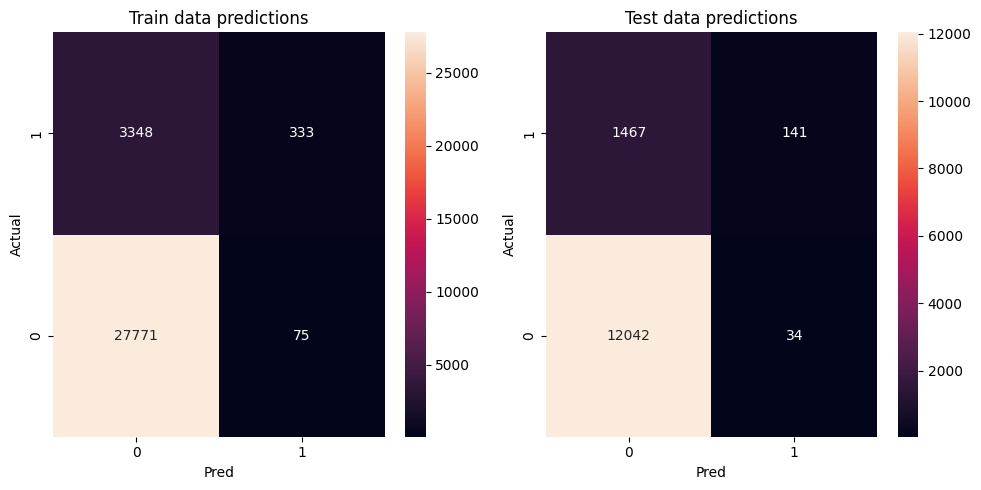

In [20]:
make_confusion_matrix_chart(train_cm, test_cm)

### make ROC chart and PR curve

In [21]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        results_collect = rdd.collect()
        for row in results_collect:
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [22]:
import matplotlib.pyplot as plt

def plot_roc_pr(df, target_variable_name, plot_type, legend_value, title):

    preds = df.select(target_variable_name,'probability')
    preds = preds.rdd.map(lambda row: (float(row['probability'][1]), float(row[target_variable_name])))
    # Returns as a list (false positive rate, true positive rate)
    points = CurveMetrics(preds).get_curve(plot_type)
    plt.figure()
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    plt.title(title)

    if plot_type == 'roc':
        plt.xlabel('False Positive Rate (1-Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.plot(x_val, y_val, label = 'AUC = %0.2f' % legend_value)
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')

    if plot_type == 'pr':
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.plot(x_val, y_val, label = 'Average Precision = %0.2f' % legend_value)
        plt.plot([0, 1], [0.5, 0.5], color='red', linestyle='--')

    plt.legend(loc = 'lower right')
    return None

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


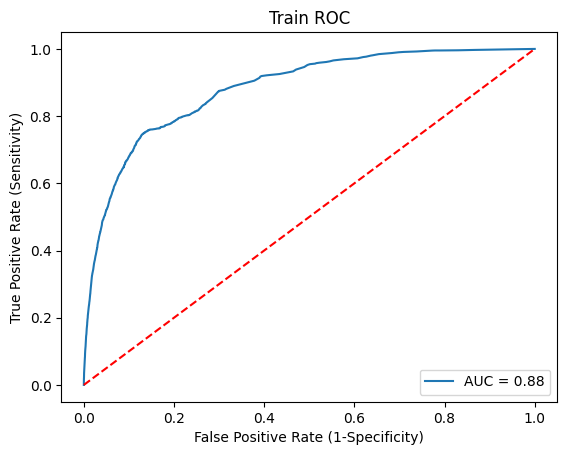

In [23]:
plot_roc_pr(train_pred_result, target_variable_name, 'roc', train_roc, 'Train ROC')

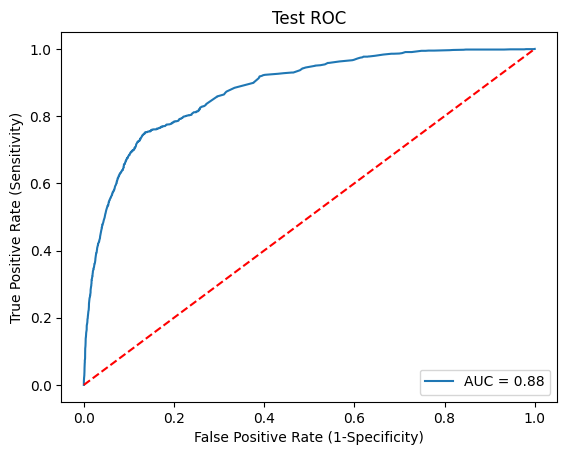

In [24]:
plot_roc_pr(test_pred_result, target_variable_name, 'roc', test_roc, 'Test ROC')

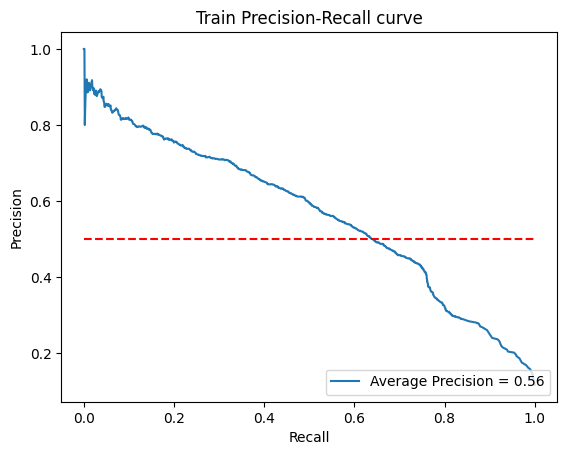

In [25]:
plot_roc_pr(train_pred_result, target_variable_name, 'pr', train_pr, 'Train Precision-Recall curve')

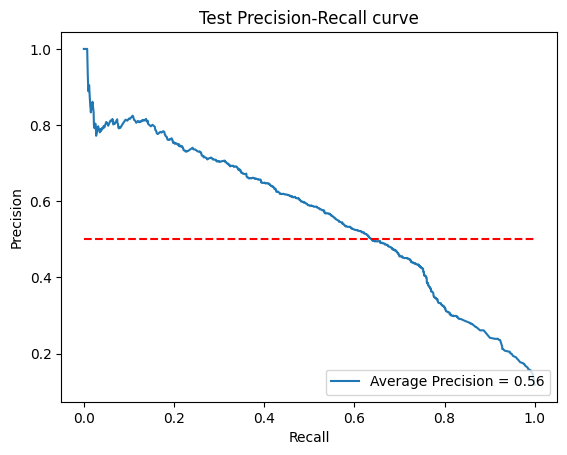

In [26]:
plot_roc_pr(test_pred_result, target_variable_name, 'pr', test_pr, 'Test Precision-Recall curve')

## Save model objects for future scoring

In [27]:
import os
import pickle

path_to_write_output = 'score_code_objects'
#create directory if not available
try:
    os.mkdir(path_to_write_output)
except:
    pass

#save pyspark objects
char_labels.write().overwrite().save(path_to_write_output + '/char_label_model.h5')
assembleModel.write().overwrite().save(path_to_write_output + '/assembleModel.h5')
clf_model.write().overwrite().save(path_to_write_output + '/clf_model.h5')

#save python objects
list_of_vars = [features_list, char_vars, num_vars]
with open(path_to_write_output + '/file.pkl', 'wb') as handle:
    pickle.dump(list_of_vars, handle)

In [28]:
import os
import zipfile

# Directory to be zipped
path_to_write_output = 'score_code_objects'
# Path for the output zip file
zip_filename = 'score_code_objects.zip'

# Create a ZipFile object in write mode
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the directory
    for root, dirs, files in os.walk(path_to_write_output):
        for file in files:
            # Create a proper path
            filepath = os.path.join(root, file)
            # Write the file to the zip archive
            # arcname strips the leading part of the path to keep only the filename
            zipf.write(filepath, arcname=os.path.relpath(filepath, os.path.dirname(path_to_write_output)))

print(f'Zip file created: {zip_filename}')


Zip file created: score_code_objects.zip


# Score code

In [29]:
### helper functions - this will be put in a separate file
#helper functions
from pyspark.sql import functions as F
import pickle
from pyspark.ml import PipelineModel
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, DoubleType

# read model objects saved from the training process
path_to_read_objects = 'score_code_objects'



In [30]:
#pyspark objects
char_labels = PipelineModel.load(path_to_read_objects + '/char_label_model.h5')
assembleModel = PipelineModel.load(path_to_read_objects + '/assembleModel.h5')
clf_model = RandomForestClassificationModel.load(path_to_read_objects + '/clf_model.h5')
#python objects
with open(path_to_read_objects + '/file.pkl', 'rb') as handle:
    features_list, char_vars, num_vars = pickle.load(handle)


In [31]:
#make necessary transformations
def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([F.col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

In [32]:
# score the new data
def score_new_df(scoredf):
    X = scoredf.select(features_list)
    X = char_labels.transform(X)
    X = X.select([c for c in X.columns if c not in char_vars])
    X = rename_columns(X, char_vars)
    final_X = assembleModel.transform(X)
    final_X.cache()
    pred = clf_model.transform(final_X)
    pred.cache()
    split_udf = udf(lambda value: value[1].item(), DoubleType())
    pred = pred.select('prediction', split_udf('probability').alias('probability'))
    return pred

In [36]:
# import necessary packages
from pyspark.sql import SparkSession
from helper import *

# new data to score
filename = 'sample_data/score_data.csv'
spark = SparkSession.builder.getOrCreate()
score_data = spark.read.csv(filename, header=True, inferSchema=True, sep=';')

#score the data
path_to_output_scores = '.'
final_scores_df = score_new_df(score_data)
#final_scores_df.show()
final_scores_df.repartition(1).write.format('csv').mode("overwrite").options(sep='|', header='true').save(path_to_output_scores + "/predictions.csv")